# HW2P2: Face Classification and Verification


Congrats on coming to the second homework in 11785: Introduction to Deep Learning. This homework significantly longer and tougher than the previous homework. You have 2 sub-parts as outlined below. Please start early!


*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7001 identities
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



### Code Structure
* Environment Setup
The notebook begins by installing the necessary Python packages using !pip.

* Imports and Kaggle Setup
The code then imports various libraries such as torch, numpy, pandas, and others. Additionally, it sets up the Kaggle environment by installing the Kaggle package, creating a directory, and adding Kaggle credentials.

* Dataset Loading
The next task done is dataset loading by accessing the data with the given ID.

* Configuration
The script specifies configuration settings, including batch size, context size, learning rate, and the number of epochs.

* Data Loaders
Using PyTorch's DataLoader, the script constructs data loaders for the train, validation, and test datasets.

* Neural Network Architecture
The notebook defines a neural network architecture using PyTorch. The architecture is based on a Squeeze-and-Excitation ResNet model (SEResNet) with basic blocks.

* Training Loop
The training loop logs metrics using Weights and Biases (wandb) and provides functions for training and evaluation. The model is saved when the validation loss decreases.

* Testing
Using the trained model and the test set, the script makes predictions and generates a CSV file containing the test predictions.

* Submitting to Kaggle
The code includes a line to submit the predictions to the Kaggle competition using the Kaggle API.


### Instructions to Run the Code
* Downloading Data from Kaggle:

* Use the Kaggle CLI (!kaggle) to download data from the competition with the competition ID 11785-hw2p2-f23.Creating a Directory to Store Data:

* Create a directory named data within the /kaggle/working/ directory to organize the project's working directory. Unzipping the Downloaded Data:

* Unzip the downloaded data into the data directory.

### Experiments

During the course of the project, I trained around 539 epochs by thoroughly exploring several neural network architectures. Two different iterations of a ResNet-like model with different configurations were one of the architectures that were experimented with. While the second setup used a learning rate of 0.0004, the same batch size,the first configuration used a learning rate of 0.1. I also tried with two more strong designs, which showed noteworthy performance: a SE-ResNet and a bespoke version of ResNet. With a total of 20,971,353 parameters, the custom ResNet included a sequence of residual blocks with increasing layer counts in each step.Conversely, the SE-ResNet achieved great accuracy on the task by integrating Squeeze-and-Excitation blocks into its fundamental block structure. Through these many trials, I was able to learn more about how decisions about architecture and configuration affected the overall performance of my models.




# Preliminaries

In [1]:
!nvidia-smi # to see what GPU you have

Thu Mar  7 09:35:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              25W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install wandb --quiet

In [3]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision #This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [5]:
# from google.colab import drive # Link your drive if you are a colab user
# drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it her

# TODOs
As you go, please read the code and keep an eye out for TODOs!

# Download Data from Kaggle

In [6]:
# TODO: Use the same Kaggle code from HW1P2

!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"leonard250","key":"2f9461ced39b0687292591bf1315ae7a"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73248 sha256=f4c2e63e5409802712676cfb561dd222e615b0ac71c81969076e001b642ef7c0
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.6
    Uninstalling kaggle-1.6.6:
      Successfully uninstalled kaggle-1.6.6


In [7]:
# !kaggle competitions download -c 11-785-f23-hw2p2-classification
# !kaggle competitions download -c 11-785-f23-hw2p2-verification

In [8]:
# !unzip -qo '11-785-f23-hw2p2-classification.zip' -d '/kaggle/working'
# !unzip -qo '11-785-f23-hw2p2-verification.zip' -d '/kaggle/working'

In [9]:
# Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/kaggle/working/'

!kaggle competitions download -c 11785-hw2p2-face-recognition
!unzip -qo '11785-hw2p2-face-recognition.zip' -d '/kaggle/working/'

!kaggle competitions download -c 11785-hw2p2-face-verification
!unzip -qo '11785-hw2p2-face-verification.zip' -d '/kaggle/working/'

mkdir: cannot create directory '/kaggle/working/': File exists
100%|█████████████████████████████████████▉| 1.71G/1.71G [01:16<00:00, 26.6MB/s]
100%|██████████████████████████████████████| 1.71G/1.71G [01:16<00:00, 24.1MB/s]
 89%|█████████████████████████████████▉    | 15.0M/16.8M [00:03<00:00, 9.31MB/s]
100%|██████████████████████████████████████| 16.8M/16.8M [00:03<00:00, 5.49MB/s]


# Configs

# Classification Dataset

In [10]:


config = {
    'batch_size': 128,  # Adjust based on GPU memory, can increase if GPU allows.
    'lr': 0.15,         # Learning rate for the optimizer
    'epochs': 15,      # Number of training epochs
    'patience': 1
    
    
}

In [11]:
DATA_DIR    = '/kaggle/working/11-785-s24-hw2p2-classification/'# TODO: Path where you have downloaded the data
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")



# Transforms using torchvision - Refer https://pytorch.org/vision/stable/transforms.html

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomPerspective(0.3, 0.3),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
    torchvision.transforms.RandomRotation(degrees= 10),
    torchvision.transforms.RandomHorizontalFlip(p=0.2),
    #torchvision.transforms.RandomGrayscale(p=0.1),
    #torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])# Implementing the right train transforms/augmentation methods is key to improving performance.
# Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
# But there are some transforms which are performed after ToTensor() : e.g - Normalization
# Normalization Tip - Do not blindly use normalization that is not suitable for this dataset

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform= valid_transforms)
# You should NOT have data augmentation on the validation set. Why?


# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config['batch_size'],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 4
)

In [12]:
# You can do this with ImageFolder as well, but it requires some tweaking
class ClassificationTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [13]:
test_dataset = ClassificationTestDataset(TEST_DIR, transforms = valid_transforms) #Why are we using val_transforms for Test Data?
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False,
                         drop_last = False, num_workers = 2)

In [14]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  128
Train batches        :  1094
Val batches          :  274


## Data visualization

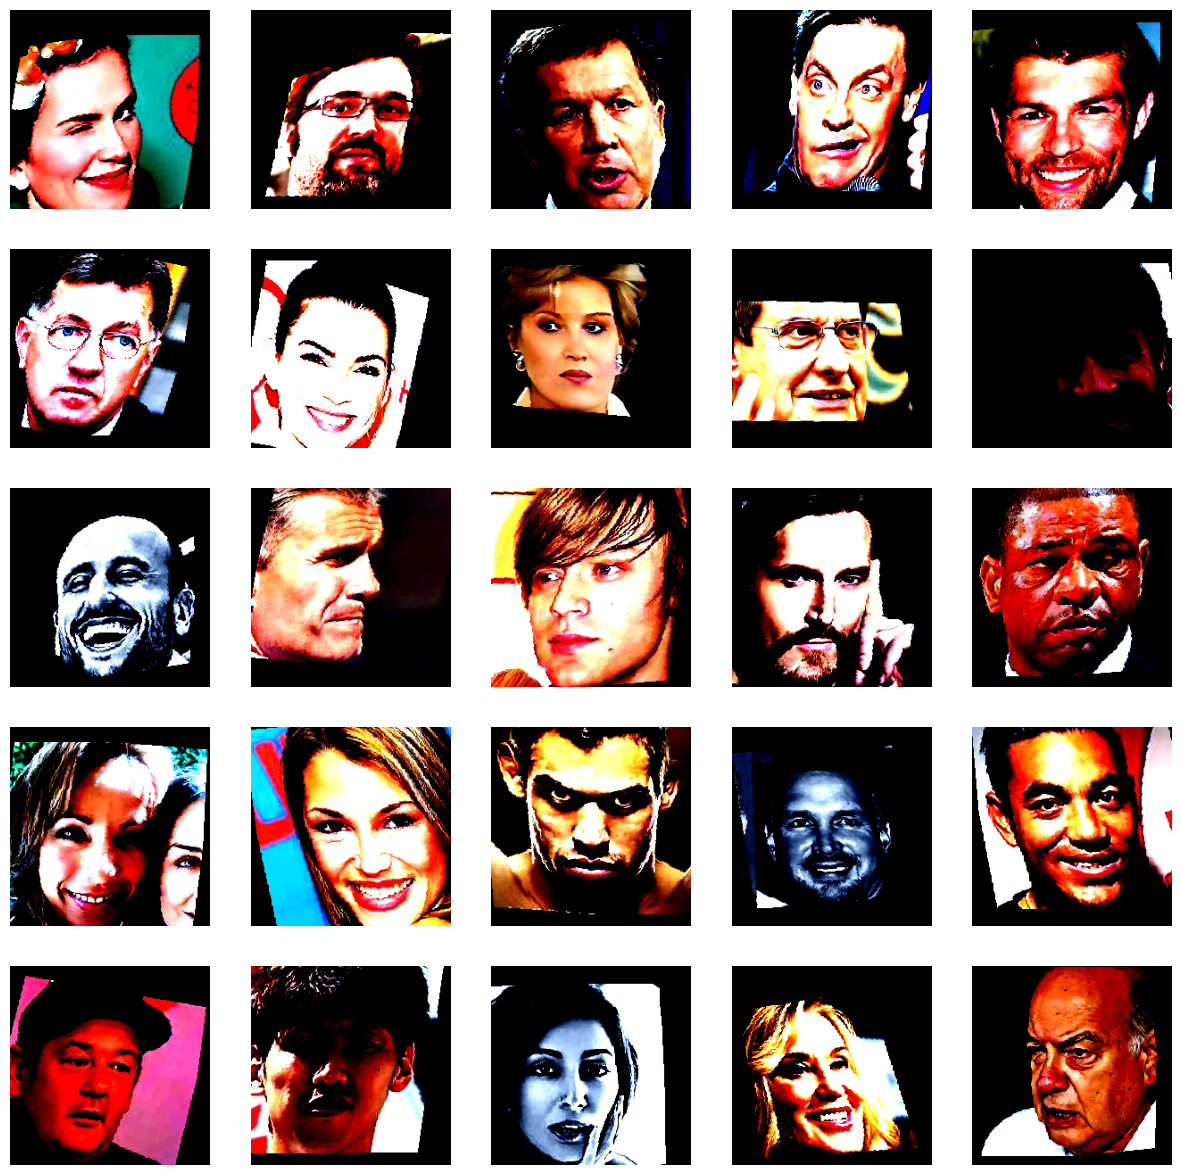

In [15]:
# Visualize a few images in the dataset
# You can write your own code, and you don't need to understand the code
# It is highly recommended that you visualize your data augmentation as sanity check

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True,
)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Very Simple Network (for Mandatory Early Submission)

In [16]:

import torch.nn as nn

class SqueezeExcitationBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Global average pooling
        out = self.global_avg_pool(x).squeeze(-1).squeeze(-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.unsqueeze(-1).unsqueeze(-1)
        return x * out

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se_block = SqueezeExcitationBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Apply SE block
        out = self.se_block(out)

        # Adjust dimensions of residual if needed
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class SEResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(SEResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Global average pooling and fully-connected layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x, return_feats=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        out = self.fc(x)

        if return_feats:
            return x
        else:
            return out

model = SEResNet(BasicBlock, [4, 4, 4, 2], num_classes=7001).to(DEVICE)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

summary(model, (3, 224, 224))

Number of parameters: 17979721
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
AdaptiveAvgPool2d-10             [-1, 64, 1, 1]               0
           Linear-11                    [-1, 4]             260
             ReLU-12                    [-1, 4]               0
           Linear-13                   [-1, 64]             320
        

# Setup everything for training

In [17]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.2) 
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=1e-4)
# TODO: Implement a scheduler (Optional but Highly Recommended)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=config["patience"], factor=0.75, verbose=True)

# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you


# Let's train!

In [18]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,

        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [19]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [20]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [21]:
wandb.login(key="af28e15472d2b0ef281fdacbb101cc157ad1b80d") #API Key is in your wandb account, under settings (wandb.ai/settings

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [22]:
# Create your wandb run
run = wandb.init(
    name = "medium-submission", ## Wandb creates random run names if you skip this field
    #reinit = True, ### Allows reinitalizing runs when you re-run this cell
    id = "h8vp9pd0",### Insert specific run id here if you want to resume a previous run
    resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: Currently logged in as: lniyiteg. Use `wandb login --relogin` to force relogin


# Experiments

In [23]:
### Save your model architecture as a string with str(model)
model_arch  = str(model)

### Save it in a txt file
arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
wandb.save('model_arch.txt')

['/kaggle/working/wandb/run-20240307_093846-h8vp9pd0/files/model_arch.txt']

# Verification Task: Validation

The verification task consists of the following generalized scenario:
- You are given X unknown identitites
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities.

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [24]:
# This obtains the list of known identities from the known folder
known_regex = "/kaggle/working/11-785-s24-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "/kaggle/working/11-785-s24-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "/kaggle/working/11-785-s24-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

100%|██████████| 960/960 [00:00<00:00, 9099.03it/s]


In [25]:
def test(model, dataloader):
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
    test_results = []

    for i, (images) in enumerate(dataloader):
        # TODO: Finish predicting on the test set.
        images = images.to(DEVICE)

        # Set the model to evaluation mode and use torch.no_grad()
        with torch.no_grad():
            outputs = model(images)

        outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
        test_results.extend(outputs)

        batch_bar.update()

    batch_bar.close()
    return test_results


In [26]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

  

    if mode == 'val':
        true_ids = pd.read_csv('/kaggle/working/11-785-s24-hw2p2-verification/verification_dev.csv')['label'].tolist()
        accuracy = accuracy_score(pred_id_strings, true_ids)
      #print("Verification Accuracy = {}".format(accuracy))

        return accuracy, pred_id_strings
    if mode == "test":
        return pred_id_strings

In [27]:
def experiment():
    best_valacc = 0


# Iterate over number of epochs to train and evaluate your model
    torch.cuda.empty_cache()
    gc.collect()
    wandb.watch(model, log="all")

    for epoch in range(config['epochs']):

        curr_lr = float(optimizer.param_groups[0]['lr'])

        train_acc, train_loss = train(model, train_loader, optimizer, criterion)

        print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
            epoch + 1,
            config['epochs'],
            train_acc,
            train_loss,
            curr_lr))

        val_acc, val_loss = validate(model, valid_loader, criterion)

        print("Val Acc (classification) {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))
        
        ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='val')

        print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))
        
        wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc,
               'validation_loss': val_loss, "learning_Rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently.

        scheduler.step(val_loss)

    # #Save model in drive location if val_acc is better than best recorded val_acc
        if val_acc >= best_valacc:
#         path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
            print("Saving model")
            torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc,
                  'epoch': epoch},'./checkpoint4.pth')
            wandb.save('checkpoint4.pth')
            best_valacc = val_acc
            torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, './checkpoint_verification.pth')
            wandb.save('checkpoint_verification.pth')
            print("Saved verification model")

### Finish your wandb run
    run.finish()

In [28]:
try:
    artifact1 = wandb.restore("checkpoint_verification.pth")
    artifact2 = wandb.restore("checkpoint_verification.pth")
    gc.collect()
    wandb.watch(model, log="all")
    # Check if the artifact is valid
    if artifact1 is not None and artifact2 is not None:
        for i,artifact in enumerate([artifact2]):
            best_val_acc = 0.0
            checkpoint_path = artifact.name

            # Load checkpoint if exists
            if os.path.exists(checkpoint_path):
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                #print(checkpoint['optimizer_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint.get('epoch', 1)
                best_val_acc = checkpoint.get('val_acc', 0)
                if i==0:
                    best_class_acc=best_val_acc
                    print(best_class_acc)
                else:
                    best_ver_acc = best_val_acc
                    print(best_ver_acc)



            else:
                start_epoch = 1
                best_val_acc = 0.0
except Exception as ex:
    print(f"Exception is thrown because {ex}")
    pass

0.5277777777777778


In [ ]:
#wandb.init(project="hw2p2 ablations", entity="01 face verification & face classification")

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    val_acc = checkpoint['val_acc']
    return model, optimizer, scheduler, epoch, val_acc


# Load the checkpoint if available
start_epoch = 0
checkpoint_classification_path = './checkpoint_4.pth'
checkpoint_verification_path = './checkpoint_verification.pth'

# if os.path.exists(checkpoint_classification_path):
#     print("Loading classification checkpoint...")
#     model, optimizer, scheduler, start_epoch, best_class_acc = load_checkpoint(checkpoint_classification_path)
    
experiment()

# if os.path.exists(checkpoint_verification_path):
#     print("Loading verification checkpoint...")
#     model, optimizer, scheduler, start_epoch, best_ver_acc = load_checkpoint(checkpoint_verification_path)
#     experiment()
# else:
#     print("the checkpoint paths does not exist")
#     print("starting from scratch")
#     experiment()



Epoch 1/15: 
Train Acc 99.1773%	 Train Loss 2.6255	 Learning Rate 0.0048


Val Acc (classification) 85.2275%	 Val Loss 3.3709


Val Acc (Verification) 0.3389%	 
Saving model
Saved verification model



Epoch 2/15: 
Train Acc 99.4480%	 Train Loss 2.5558	 Learning Rate 0.0048


Val Acc (classification) 86.6931%	 Val Loss 3.2421


Val Acc (Verification) 0.3722%	 
Saving model
Saved verification model



Epoch 3/15: 
Train Acc 99.5822%	 Train Loss 2.5360	 Learning Rate 0.0048


Val Acc (classification) 86.6560%	 Val Loss 3.2465


Val Acc (Verification) 0.3528%	 


Train:  29%|██▉       | 315/1094 [01:39<03:58,  3.27it/s, acc=99.6900%, loss=2.5204, lr=0.0048, num_correct=40195]

# Classification Task: Testing

In [ ]:
def test(model, dataloader):
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
    test_results = []

    for i, (images) in enumerate(dataloader):
        # TODO: Finish predicting on the test set.
        images = images.to(DEVICE)

        # Set the model to evaluation mode and use torch.no_grad()
        with torch.no_grad():
            outputs = model(images)

        outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
        test_results.extend(outputs)

        batch_bar.update()

    batch_bar.close()
    return test_results


In [ ]:
test_results = test(model, test_loader)

## Generate csv to submit to Kaggle

In [ ]:
# verification eval
accuracy, pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config['batch_size'], mode='val')
# verification test
pred_id_strings = eval_verification(unknown_test_images, known_images, model, similarity_metric, config['batch_size'], mode='test')

In [ ]:
with open("classification_early_submission7.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))
        
with open("verification_early_submission7.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
# !kaggle competitions submit -c 11-785-f23-hw2p2-classification -f classification_early_submission.csv -m "early submission"
!kaggle competitions submit -c 11785-hw2p2-face-recognition -f classification_early_submission7.csv -m "Early-Submission"

# !kaggle competitions submit -c 11-785-f23-hw2p2-verification -f verification_early_submission.csv -m "early submission"
!kaggle competitions submit -c 11785-hw2p2-face-verification -f verification_early_submission7.csv -m "Early-Submission"